In [78]:
from neural_bench.network import Network
from neural_bench.fc_layer import FCLayer
from neural_bench.quantized_layer import QuantizedLayer
from neural_bench.activation_layer import ActivationLayer
from neural_bench.activations import tanh, tanh_prime, gelu, gelu_prime
from neural_bench.losses import mse, mse_prime

from keras.datasets import mnist
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt


SIZE=20000

Now start loading the data

In [80]:
(train_images, train_labels), (raw_test, test_labels) = mnist.load_data()
# training data : 60000 samples
# reshape and normalize input data
train_images = train_images.reshape(train_images.shape[0], 1, 28*28)
train_images = train_images.astype('float32')
train_images /= 255
# encode output which is a number in range [0,9] into a vector of size 10
# e.g. number 3 will become [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
train_labels = to_categorical(train_labels)

# same for test data : 10000 samples
test_images = raw_test.reshape(raw_test.shape[0], 1, 28*28)
test_images = test_images.astype('float32')
test_images = test_images / 255.0
# test_labels = to_categorical(test_labels)

In [81]:
test_labels[0:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], dtype=uint8)

In [82]:
train_labels[0:10]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

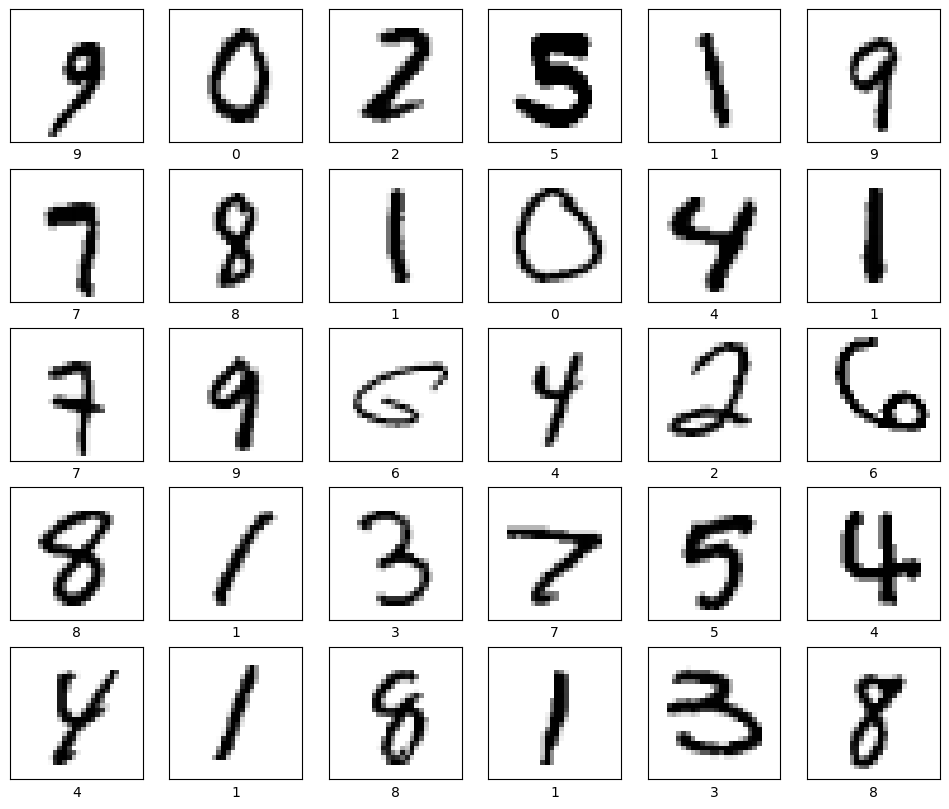

In [83]:
plt.figure(figsize=(12,10))
for i in range(30):
    plt.subplot(5,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(raw_test[i+1000], cmap=plt.cm.binary)
    plt.xlabel(test_labels[i+1000])
plt.show()

# Build the model

Let's build a network with three layers: input, hidden, output and adding an activation layer explicitely after each layer

In [84]:
net = Network()
# net.add(FCLayer(28*28, 100))                # input_shape=(1, 28*28)    ;   output_shape=(1, 100)
# net.add(ActivationLayer(tanh, tanh_prime))
# net.add(FCLayer(100, 50))                   # input_shape=(1, 100)      ;   output_shape=(1, 50)
# net.add(ActivationLayer(tanh, tanh_prime))
# net.add(FCLayer(50, 10))                    # input_shape=(1, 50)       ;   output_shape=(1, 10)
# net.add(ActivationLayer(tanh, tanh_prime))

net.add(FCLayer(28*28, 64))                # input_shape=(1, 28*28)    ;   output_shape=(1, 100)
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(64, 10))                    # input_shape=(1, 50)       ;   output_shape=(1, 10)
net.add(ActivationLayer(tanh, tanh_prime))

# net.add(FCLayer(28*28, 100))                # input_shape=(1, 28*28)    ;   output_shape=(1, 100)
# net.add(ActivationLayer(gelu, gelu_prime))
# net.add(FCLayer(100, 50))                   # input_shape=(1, 100)      ;   output_shape=(1, 50)
# net.add(ActivationLayer(gelu, gelu_prime))
# net.add(FCLayer(50, 10))                    # input_shape=(1, 50)       ;   output_shape=(1, 10)
# net.add(ActivationLayer(gelu, gelu_prime))
net.use(mse, mse_prime)

we can start training

In [85]:
print('Start training')
net.fit(train_images[0:SIZE], train_labels[0:SIZE], epochs=10, learning_rate=0.1)

Start training
Training: [####################] 10/10 Done...               


Time to test

In [86]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
# allow ourselves to offset in the test_images array
offset = 200
predictions = net.predict(test_images[0+offset:num_images+offset])

# predictions[0][0]
predictions[0:3]

[array([[-0.04058033,  0.08059324, -0.0112722 ,  0.80071481,  0.04807621,
          0.11964465, -0.02881676,  0.01810977, -0.11245079,  0.06549102]]),
 array([[-0.08385204, -0.00832994, -0.00865507,  0.17654527,  0.09779833,
         -0.06730258,  0.96027537, -0.01321678, -0.12540307,  0.0370477 ]]),
 array([[-0.00657906,  0.98548758, -0.14606933,  0.10336868, -0.00776492,
         -0.09907109, -0.03844404, -0.06115929, -0.08399019, -0.09178309]])]

In [88]:
np.argmax(predictions[0])

3

In [89]:
len(predictions)

15

In [90]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

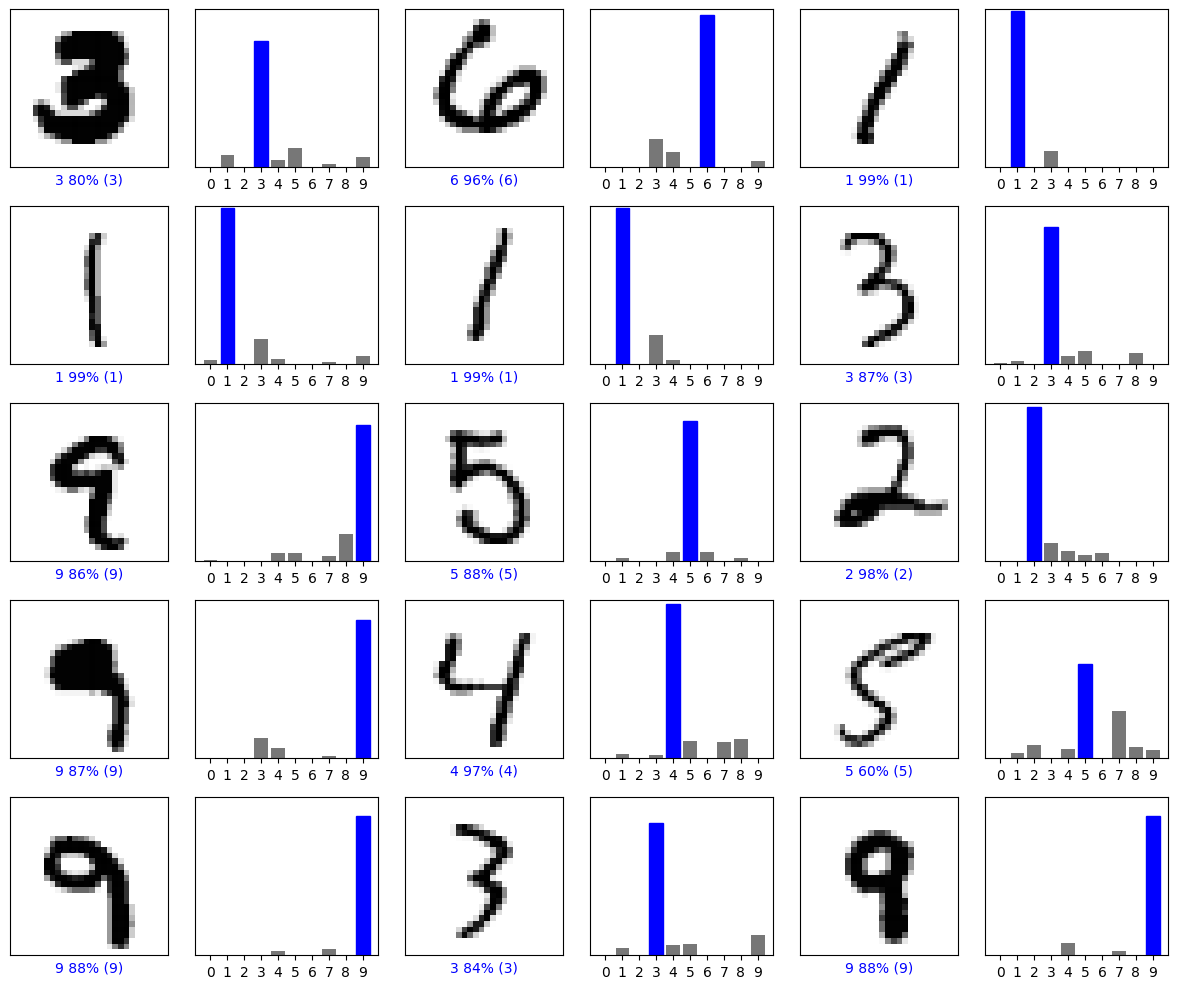

In [91]:
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i+offset, predictions[i][0], test_labels, raw_test)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i+offset, predictions[i][0], test_labels)
plt.tight_layout()
plt.show()